## Imports

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


# from sklearn.linear_model import LogisticRegression #dont need
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

# from src.utils.pandas_extensions import one_hot_encoding

## Functions

In [150]:
def replace_known_zero(df: pd.DataFrame, column: str) -> None:
    df[column] = df[column].replace("none", 0)
    df[column] = df[column].replace(np.nan, 0)
    # print(processed_data["Support Calls"].value_counts())
    df[column] = df[column].astype("float")

def clean_data(dataframe: pd.DataFrame, drop: bool = True) -> pd.DataFrame:
    # print(dataframe.info())
    processed_data = dataframe.copy() 

    # processed_data = one_hot_encoding(processed_data, "Subscription Type")
    processed_data = one_hot_encoding(processed_data, "Contract Length")
    processed_data = one_hot_encoding(processed_data, "Customer Status", possible_values=["active", "inactive"])

    for col in ["Support Calls", "Tenure", "Payment Delay", "Last Interaction"]:
        replace_known_zero(processed_data, column=col)
    # replace_known_zero(processed_data, column="Support Calls")
    # replace_known_zero(processed_data, column="Payment Delay")
    # replace_known_zero(processed_data, column="Last Interaction")

    if drop:
        processed_data = processed_data.dropna()

    return processed_data

def one_hot_encoding(dataframe: pd.DataFrame, column: str, possible_values: list[str] = []) -> pd.DataFrame:
    if (column not in dataframe.columns):
        raise AssertionError(f"Column {column} doesn't exist")
    
    nparr = dataframe[column].value_counts()
    
    for new_col in possible_values:
        new_series = dataframe[column] == new_col
        dataframe[f"{column}_{new_col}"] = new_series

    for new_col in nparr.index:
        new_series = dataframe[column] == new_col
        dataframe[f"{column}_{new_col}"] = new_series


    return dataframe

In [152]:
features = ["Usage Frequency", "Age", "Support Calls", "Last Interaction", "Payment Delay", "Total Spend", 
            "Contract Length_Monthly", 
            # "Customer Status_inactive", "Customer Status_active"
        ]
depth_limit = 8

## Load data

In [153]:
unprocessed_data = pd.read_csv("../data/raw/train.csv")
unprocessed_data.head()
# unprocessed_data["Contract Length"].value_counts()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Customer Status,Last Due Date,Last Payment Date,Churn
0,160831,34,Male,NaN,26,none,17.0,Basic,Quarterly,890.21,30.0,active,06-21,07-08,0
1,354435,30,Male,36.0,22,NaN,15.0,Basic,Annual,954.37,30.0,active,06-10,06-25,0
2,444576,23,Male,44.0,14,none,NaN,Premium,Annual,674.00,21.0,inactive,06-27,07-21,1
3,130847,24,Male,39.0,21,2,14.0,Standard,Quarterly,775.00,18.0,active,06-30,07-14,0
4,108121,26,Male,NaN,26,1,5.0,Basic,Quarterly,679.45,NaN,active,06-29,07-04,0


In [154]:
np.random.seed(311)
processed_data = clean_data(unprocessed_data)
X = processed_data[features]
# X = processed_data
y = processed_data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [151]:
# print(unprocessed_data.head(n=20))
test_df = clean_data(unprocessed_data, drop=False)
test_df[test_df.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Customer Status,Last Due Date,Last Payment Date,Churn,Contract Length_Annual,Contract Length_Quarterly,Contract Length_Monthly,Customer Status_active,Customer Status_inactive


In [155]:
#try ph with depth 1, ph with depth 4, ph with depth None
#try N as the features with the same depth value
#try cycle through the rest of the fa
# features = ["Usage Frequency", "Age", "Subscription Type_Premium", "Subscription Type_Basic", "Subscription Type_Standard"]
model = DecisionTreeClassifier(criterion='entropy', max_depth=depth_limit)
model.fit(X_train[features], y_train)

#Predict on train data
y_pred_train = model.predict(X_train[features])

#Predict on test data
y_pred_test = model.predict(X_test[features])

train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
train_f1_score = metrics.f1_score(y_train, y_pred_train)
train_auc_score = metrics.roc_auc_score(y_train, y_pred_train)
testing_accuracy = metrics.accuracy_score(y_test, y_pred_test)
testing_f1_score = metrics.f1_score(y_test, y_pred_test)
testing_auc_score = metrics.roc_auc_score(y_test, y_pred_test)

print("---------Training performance---------")
print(f"{train_accuracy=}")
print(f"{train_f1_score=}")
print(f"{train_auc_score=}")
print("---------Testing performance---------")
print(f"{testing_accuracy=}")
print(f"{testing_f1_score=}")
print(f"{testing_auc_score=}")

---------Training performance---------
train_accuracy=0.9747815595750898
train_f1_score=0.9577493703069112
train_auc_score=0.9685611363485486
---------Testing performance---------
testing_accuracy=0.9730035848600145
testing_f1_score=0.9548289756941251
testing_auc_score=0.9665808073372645


## Exploring Results

In [ ]:
plt.figure(figsize=(3,3))
plot_tree(model, feature_names=features, filled=True)
plt.title(f"Descision Tree ({features=}, {depth_limit=})")

[4.63895422e-04 1.89767362e-02 2.61756474e-02 2.56984230e-03
 9.09015102e-01 2.47742082e-02 1.80245686e-02] ['Usage Frequency', 'Age', 'Support Calls', 'Last Interaction', 'Payment Delay', 'Total Spend', 'Contract Length_Monthly']
7 7


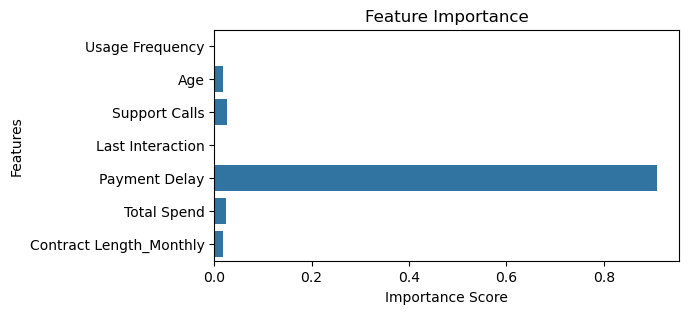

In [156]:
importances = model.feature_importances_
print(importances, features)
print(len(importances), len(features))

# Display feature importance
plt.figure(figsize=(6,3))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')          
plt.show()

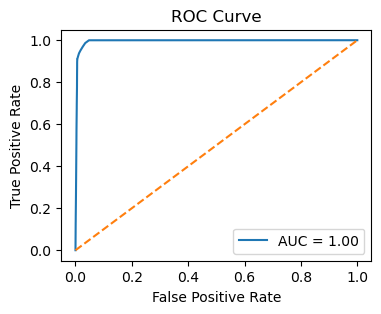

In [157]:
# AUC-ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
roc_auc = metrics.roc_auc_score(y_test, y_prob)

plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Submission

### Load Submission

In [158]:
submission_df = pd.read_csv("../data/raw/test.csv")

In [115]:
for col in submission_df.columns:
    print(submission_df[col].value_counts())

CustomerID
262106    1
233745    1
190967    1
259611    1
6908      1
         ..
371859    1
285097    1
367255    1
94729     1
132430    1
Name: count, Length: 133776, dtype: int64
Age
37    2930
47    2914
50    2903
33    2902
46    2901
34    2894
42    2893
31    2882
43    2880
48    2874
45    2870
39    2860
35    2845
49    2841
38    2826
23    2825
44    2820
30    2817
40    2808
24    2792
41    2792
29    2791
25    2790
59    2785
36    2781
22    2778
55    2761
18    2758
26    2755
27    2753
20    2751
65    2750
57    2742
61    2740
51    2739
54    2736
63    2732
60    2731
28    2730
64    2712
52    2692
53    2689
56    2684
58    2684
32    2684
21    2673
19    2646
62    2640
Name: count, dtype: int64
Gender
Female    67449
Male      66327
Name: count, dtype: int64
Tenure
55.0    1927
37.0    1894
56.0    1881
57.0    1878
52.0    1873
34.0    1872
46.0    1870
39.0    1866
53.0    1866
29.0    1864
44.0    1861
47.0    1858
38.0    1858
60.0    1857
27.

In [159]:
test_data = pd.read_csv("../data/raw/test.csv")
test_data["Support Calls"].value_counts()
test_data = clean_data(test_data, drop=False)
print(test_data)
test_prob = model.predict_proba(test_data[features])
test_pred = test_prob[:,1]

        CustomerID  Age  Gender  Tenure  Usage Frequency  Support Calls  \
0           262106   65    Male    16.0               16            3.0   
1            37061   23    Male     0.0               12            3.0   
2           361832   49    Male     0.0               25            2.0   
3           425516   25  Female    48.0               11            7.0   
4            60597   52  Female     4.0               10            6.0   
...            ...  ...     ...     ...              ...            ...   
133771      396573   19    Male    47.0               17            4.0   
133772      452602   27    Male    42.0                5            9.0   
133773      424958   38  Female     0.0               17            9.0   
133774      242104   34    Male    44.0                3            9.0   
133775      132430   31    Male     0.0                7            0.0   

        Payment Delay Subscription Type Contract Length  Total Spend  \
0                14.0      

In [160]:
export = test_data[["CustomerID"]]
export["Churn"] = test_pred

date = datetime.now()
export.to_csv("../data/processed/export" + str(date).replace(":", "") + ".csv", index=False)

C:\Users\Scott\AppData\Local\Temp\ipykernel_41856\1555304509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export["Churn"] = test_pred
